# Using a decision tree to predict financial distress
### Machine Learning for Public Policy - HW #2
### Cecile Murray


Many people rely on their ability to borrow money to help cushion the impact of financial shocks such as a medical emergency or a job loss. Sometimes, however, borrowers cannot pay back what they owe, and can be sucked into a downward spiral of greater debt and declining credit-worthiness. In a policy context, the ability to identify individuals at high risk of serious delinquency could allow for interventions that would help individuals get back on a firm financial footing before their credit suffers serious damage. 

In this assignment, I explore a Kaggle dataset and use to predict who will experience a serious delinquency.

### Load  data

In [2]:
# import modules
import numpy as np
import pandas as pd 
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 

# bring in pipeline library
import pipeline as pipe

In [3]:
# read in data and look at first few rows
credit_raw = pipe.read_data("credit-data", file_type = 'csv')

# get count of null values for all columns
credit_raw.isnull().sum()

# replace missing values with the median
credit = pipe.replace_missing(credit_raw, 'MonthlyIncome', 'NumberOfDependents', method = 'median')

### Explore data

Before creating the decision tree classifier, I performed some basic exploratory analysis on the data to improve my understanding of how different variables relate to whether a person was more than 90 days delinquent in the past two years. From this analysis, I identified a few notable facts:

* About 16 percent of people in the dataset experienced a serious delinquency. 
* People who experienced a serious delinquency were about seven years younger, on average; a much smaller share of people over age 60 experienced such a delinquency.
* Unsurprisingly, the share of people with a serious delinquency was lower among those with higher monthly incomes, but the age trend persisted even after conditioning on income. Even low-income people over age 60 had relatively low rates of serious delinquency.
* People with higher credit utilization also had higher delinquency rates. 

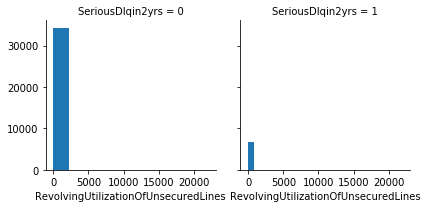

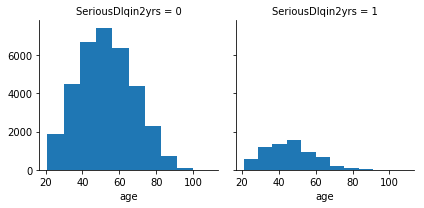

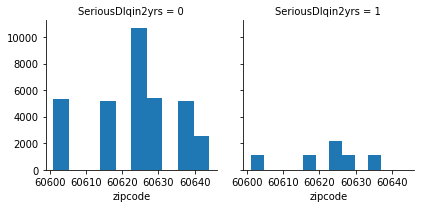

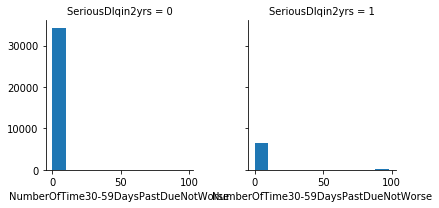

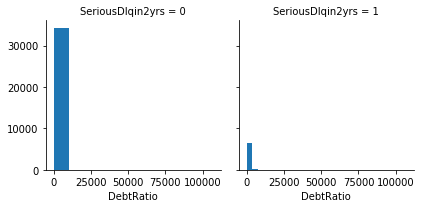

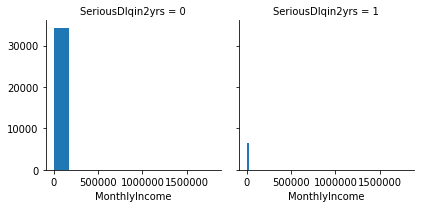

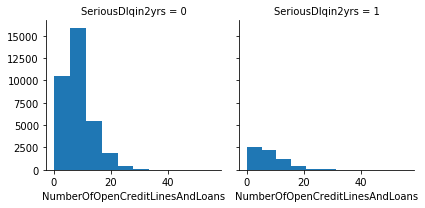

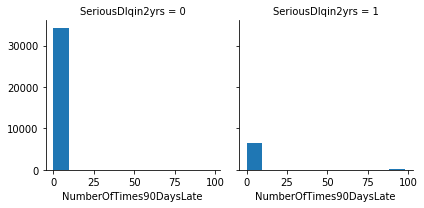

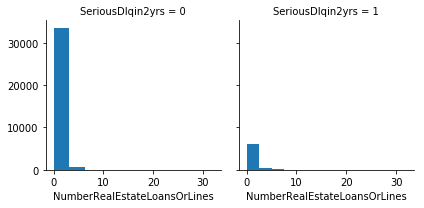

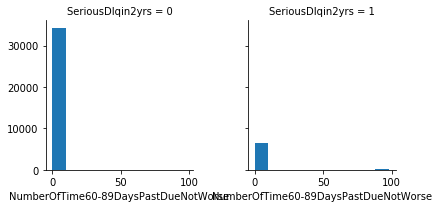

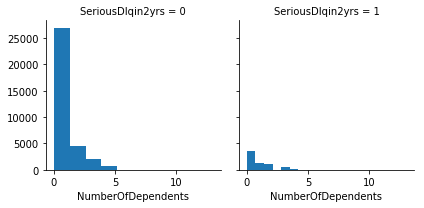

In [4]:
# make histograms of all potential features vs. target variable
plotvars = list(credit.columns[2:])
pipe.plot_cond_dist(credit, 'SeriousDlqin2yrs', *plotvars)

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


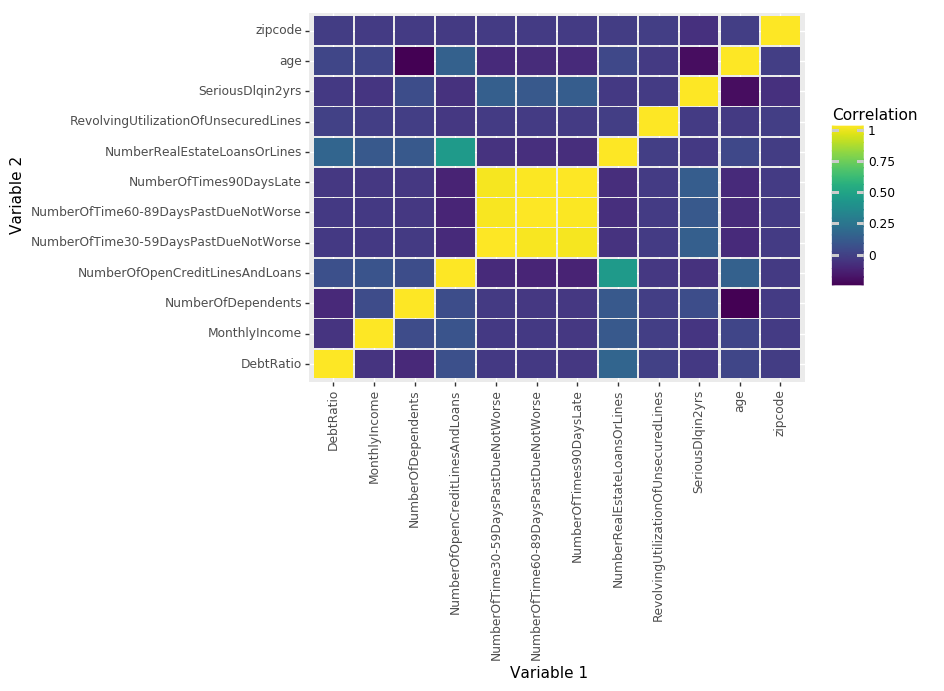

<ggplot: (-9223372029303141267)>

In [5]:
# compute correlations between all variables
pipe.plot_correlations(credit, credit.columns[1:])


In [5]:
# look for outliers in key variables
pipe.find_outliers(credit, 0, 100, 'age')
pipe.find_outliers(credit, 0, 25000, 'MonthlyIncome')
pipe.find_outliers(credit, 0, 100, 'RevolvingUtilizationOfUnsecuredLines')

# of values smaller than lower bound:  0
Series([], Name: age, dtype: int64)
# of values larger than upper bound: 2
29788    109
3738     103
Name: age, dtype: int64


# of values smaller than lower bound:  0
Series([], Name: MonthlyIncome, dtype: float64)
# of values larger than upper bound: 313
61     237400.0
419     66000.0
351     55500.0
482     42800.0
387     27500.0
Name: MonthlyIncome, dtype: float64


# of values smaller than lower bound:  0
Series([], Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64)
# of values larger than upper bound: 67
2759    12369.0
1259     4591.0
2150     2128.0
592      1924.0
2644     1917.0
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64




In [7]:
# create discrete buckets for variables
credit = pipe.bin_continuous(credit, 'age', 'age_bracket',
                         breaks = list(range(0, 100, 20)),
                         labels = ['under20', '20-40', '40-60', '60-80', '80+'])
credit = pipe.bin_continuous(credit, 'MonthlyIncome', 'income_cat',
                             breaks = [-1, 1000, 2500, 5000, 10000],
                             labels = ['low', 'modest', 'medium', 'high', 'highest'])
credit = pipe.bin_continuous(credit, 'RevolvingUtilizationOfUnsecuredLines', 'utilization',
                             breaks = [0, 0.5, 1, 2], 
                             labels = ['under_half', 'over_half', 'over_one', 'extreme'])

In [8]:
# look at conditional descriptive stats of target variable 
pipe.tab(credit, 'SeriousDlqin2yrs', 'utilization')

,count,mean,std,min,25%,50%,75%,max
utilization,,,,,,,,
under_half,25159.0,0.069399,0.254136,0.0,0.0,0.0,0.0,1.0
over_half,11714.0,0.330545,0.470429,0.0,0.0,0.0,1.0,1.0
over_one,1208.0,0.637417,0.480945,0.0,0.0,1.0,1.0,1.0
extreme,131.0,0.305344,0.462321,0.0,0.0,0.0,1.0,1.0


In [9]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'income_cat')

,count,mean,std,min,25%,50%,75%,max
income_cat,,,,,,,,
low,1229.0,0.137510,0.344525,0.0,0.0,0.0,0.0,1.0
modest,3948.0,0.227457,0.419243,0.0,0.0,0.0,0.0,1.0
medium,10557.0,0.201572,0.401193,0.0,0.0,0.0,0.0,1.0
high,20480.0,0.142285,0.349351,0.0,0.0,0.0,0.0,1.0
highest,4802.0,0.106414,0.308399,0.0,0.0,0.0,0.0,1.0


In [10]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'age_bracket')

,count,mean,std,min,25%,50%,75%,max
age_bracket,,,,,,,,
under20,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20-40,10120.0,0.239921,0.427056,0.0,0.0,0.0,0.0,1.0
40-60,19178.0,0.172124,0.377498,0.0,0.0,0.0,0.0,1.0
60-80,10490.0,0.078265,0.268601,0.0,0.0,0.0,0.0,1.0
80+,1228.0,0.057003,0.231943,0.0,0.0,0.0,0.0,1.0


In [8]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'age_bracket', 'income_cat')

count      mean       std  min  25%  50%  75%  max
age_bracket income_cat                                                      
20-40       lowest        564.0  0.163121  0.369804  0.0  0.0  0.0  0.0  1.0
            low          1638.0  0.294261  0.455849  0.0  0.0  0.0  1.0  1.0
            modest       3320.0  0.260843  0.439161  0.0  0.0  0.0  1.0  1.0
            medium       4084.0  0.220862  0.414878  0.0  0.0  0.0  0.0  1.0
            high          514.0  0.167315  0.373621  0.0  0.0  0.0  0.0  1.0
40-60       lowest        361.0  0.155125  0.362526  0.0  0.0  0.0  0.0  1.0
            low          1272.0  0.235849  0.424695  0.0  0.0  0.0  0.0  1.0
            modest       4459.0  0.225611  0.418031  0.0  0.0  0.0  0.0  1.0
            medium      10140.0  0.157002  0.363821  0.0  0.0  0.0  0.0  1.0
            high         2946.0  0.117787  0.322410  0.0  0.0  0.0  0.0  1.0
60-80       lowest        267.0  0.074906  0.263735  0.0  0.0  0.0  0.0  1.0
            low           882.0  0.121315  0.326678  0.0  0.0  0.0  0.0  1.0
            modest       2491.0  0.095544  0.294024  0.0  0.0  0.0  0.0  1.0
            medium       5568.0  0.068606  0.252806  0.0  0.0  0.0  0.0  1.0
            high         1282.0  0.057722  0.233309  0.0  0.0  0.0  0.0  1.0
80+         lowest         37.0  0.027027  0.164399  0.0  0.0  0.0  0.0  1.0
            low           156.0  0.057692  0.233912  0.0  0.0  0.0  0.0  1.0
            modest        287.0  0.062718  0.242878  0.0  0.0  0.0  0.0  1.0
            medium        688.0  0.055233  0.228600  0.0  0.0  0.0  0.0  1.0
            high           60.0  0.066667  0.251549  0.0  0.0  0.0  0.0  1.0

### Building a decision tree classifier

I use scikitlearn's DecisionTreeClassifier to predict whether individuals in this dataset are likely to have experienced a serious delinquency. I include the following features:

* Credit utilization in four groups: under 50%, 50% to 100%, 100% to 200%, and greater than 200%  
* Debt ratio
* Number of open credit lines and loans
* Number of real estate lines and loans
* Number of times an individual was delinquent for 30-59 days
* Age, in 20 year increments
* Monthly income in five brackets: low (under \\$1,000 per month), modest (from \\$1,000 to \\$2,500 per month), medium (from \\$2,500 to \\$5,000 per month), high ((from \\$5,0900 to \\$10,000 per month), and highest (\\$10,000 per month or more)
* Number of dependents

Notably, I do not use the features related to the number of times a person was more than 90 days late because this feature would align perfectly with the target variable. I also drop the number of times an individual was delinquent for 60-89 days because it is highly correlated with the number of times an individual was delinquent for 30-59 days, and the earlier indicator would be more useful for intervention. 

Lastly, I decided not to use the ZIP code variable because the numeric of a ZIP code is arbitrary. If particular ZIP codes might contain more individuals with lower incomes, this trend should be picked up in the income variable. It is possible that there are spatially-generated differences in otherwise similar individuals - perhaps individuals in one ZIP code are exposed to a community organization that helps them avoid default - but modeling this effect would require a dummy for each ZIP code. While this approach might make sense, it would complicate interpretation of results in this simplified model.

In [11]:
# make categorical variables into binaries
credit = pipe.make_cat_dummy(credit, ['age_bracket', 'income_cat', 'utilization'])

In [13]:
# create training and testing sets
feature_list = ['NumberOfTime30-59DaysPastDueNotWorse',
                'DebtRatio',
                'age_bracket_under20',
                'age_bracket_20-40',
                'age_bracket_40-60',
                'age_bracket_60-80',
                'age_bracket_80+',
                'age_bracket_nan',
                'income_cat_low',
                'income_cat_modest',
                'income_cat_medium',
                'income_cat_high',
                'income_cat_highest',
                'utilization_under_half',
                'utilization_over_half',
                'utilization_over_one',
                'utilization_extreme',
                'NumberOfOpenCreditLinesAndLoans',
                'NumberRealEstateLoansOrLines',
                'NumberOfDependents']

x_train, x_test, y_train, y_test = pipe.create_train_test_sets(credit,
                                                               'SeriousDlqin2yrs',
                                                               feature_list,
                                                               size = 0.25)

### Evaluate the classifier

I test different depths for the tree in order to see how the accuracy increases/decreases with the depths of the tree. As the tree depth increases, the tradeoff between under- and overfitting becomes apparent: the train accuracy approaches perfect while the test accuracy drops off.

In [14]:
# test different tree depths
depths = [1, 3, 5, 6, 7, 10, 15, 25]
criteria = ['gini', 'entropy']
pipe.test_tree_accuracy(x_train, y_train, x_test, y_test, 0.3, depths, criteria)

,Split Criterion,Depth,Train Accuracy,Test Accuracy
0,gini,1,0.804337,0.808563
1,gini,3,0.832358,0.831968
2,gini,5,0.838957,0.837722
3,gini,6,0.842728,0.838014
4,gini,7,0.837787,0.829530
5,gini,10,0.862753,0.834016
6,gini,15,0.904395,0.815389
7,gini,25,0.979163,0.786522
8,entropy,1,0.689032,0.691535
9,entropy,3,0.839802,0.842208


Of these trees, the one with the greatest accuracy on the test dataset is the entropy tree with a maxmimum depth of three. I plot the predicted probabilities from this tree below.

(array([5576.,  733.,  539., 1994.,    0.,  242.,  624.,    0.,    0.,
         546.]),
 array([0.02821375, 0.09088184, 0.15354994, 0.21621803, 0.27888612,
        0.34155421, 0.4042223 , 0.4668904 , 0.52955849, 0.59222658,
        0.65489467]),
 <a list of 10 Patch objects>)

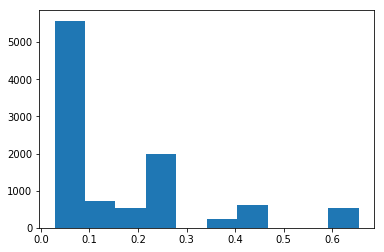

In [15]:
dec_tree = DecisionTreeClassifier(max_depth=3, criterion='entropy').fit(x_train, y_train)
pipe.plot_prediction_distribution(dec_tree, x_test)

### Plot the decision tree

By plotting the decision tree, we can understand how it classifies observations. Looking at the plot below, existing measures of credit health - namely utilization of existing revolving credit lines and the number of times an individual had a short-term delinquency - largely drive the classification. This result is not surprising, but it also may not add much knowledge from the perspective of someone who wishes to more carefully target individuals at risk of serious delinquency. 

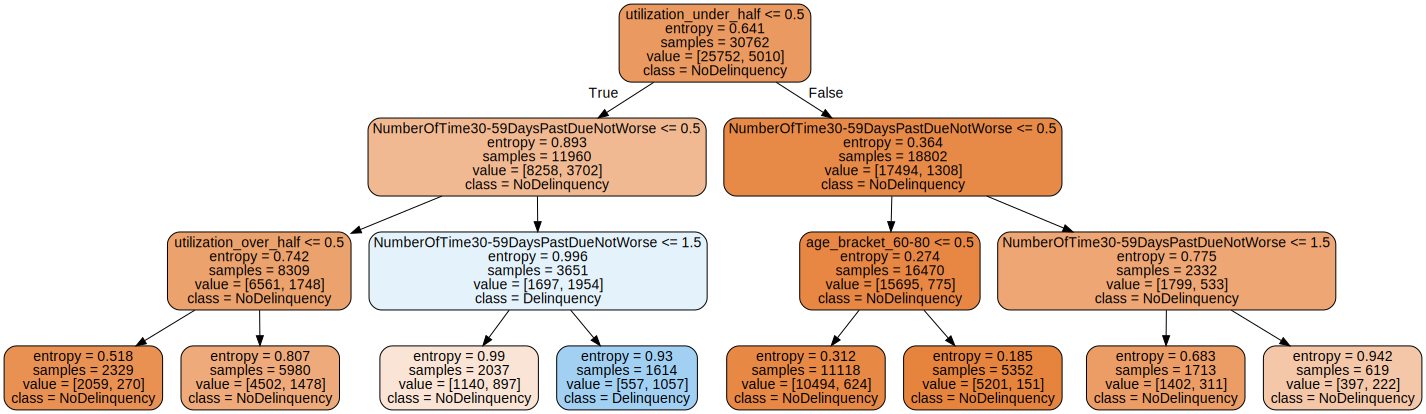

In [16]:
pipe.make_tree_chart(dec_tree, x_train.columns, ['NoDelinquency', 'Delinquency'], out_file = 'tree_entropy_d3.dot')